# Demonstrate ECM Extractors
The ECM extractors assemble the required components for Equivalent Circuit model using reference performance test data.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from battdat.data import BatteryDataset
import numpy as np

## Load an Example Dataset
We use an example RPT cycle from [the CAMP 2023 dataset](https://github.com/materials-data-facility/publishing-battery-data) to demonstrate parameter extraction

In [2]:
data = BatteryDataset.from_hdf('files/example-camp-rpt.h5')

In [3]:
data.raw_data

,cycle_number,file_number,test_time,state,current,voltage,step_index,method,substep_index,cycle_capacity,cycle_energy
0,1,0,120.042,b'charging',0.260548,3.450065,0,b'constant_current',0,0.000000,0.000000
1,1,0,139.182,b'charging',0.260090,3.470207,0,b'constant_current',0,0.001384,0.004789
2,1,0,439.182,b'charging',0.260014,3.487297,0,b'constant_current',0,0.023055,0.080177
3,1,0,739.182,b'charging',0.259937,3.493553,0,b'constant_current',0,0.044720,0.155796
4,1,0,1039.182,b'charging',0.260166,3.499809,0,b'constant_current',0,0.066391,0.231572
...,...,...,...,...,...,...,...,...,...,...,...
180,1,0,41767.320,b'hold',0.000000,3.272145,3,b'rest',8,-0.027665,0.011427
181,1,0,41777.322,b'hold',0.000000,3.276875,3,b'rest',8,-0.027665,0.011427
182,1,0,41787.318,b'hold',0.000000,3.280995,3,b'rest',8,-0.027665,0.011427
183,1,0,41797.320,b'hold',0.000000,3.284504,3,b'rest',8,-0.027665,0.011427


The dataset contain a single slow cycle that samples the entire capacity of the cell.

Text(0.5, 0, 'Time (hr)')

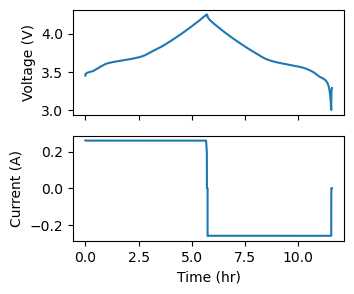

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(3.5, 3.), sharex=True)

raw_data = data.tables['raw_data']
time = (raw_data['test_time'] - raw_data['test_time'].min()) / 3600
axs[0].plot(time, raw_data['voltage'])
axs[0].set_ylabel('Voltage (V)')
axs[1].plot(time, raw_data['current'])
axs[1].set_ylabel('Current (A)')
axs[1].set_xlabel('Time (hr)')

## Determining Capacity
The `MaxCapacityExtractor` determines capacity by integrating current over time then measuring difference between the maximum and minimum change in charge state.


> Note: Integration is actually [implemented in battdat](https://rovi-org.github.io/battery-data-toolkit/user-guide/post-processing/cell-capacity.html#Step-3:-Assign-Capacities).

In [ ]:
from moirae.estimators.offline.extractors.ecm import MaxCapacityExtractor

In [6]:
cap = MaxCapacityExtractor().extract(data)
cap

MaxTheoreticalCapacity(updatable=set(), base_values=array([[1.48220808]]))

This should match up with the measured change in charge

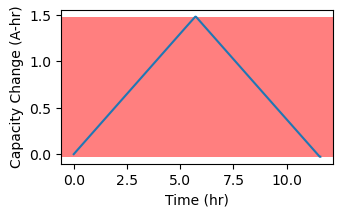

In [7]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.plot(time, raw_data['cycle_capacity'])
ax.set_xlim(ax.get_xlim())
ax.set_ylabel('Capacity Change (A-hr)')
ax.set_xlabel('Time (hr)')

min_cap, max_cap = raw_data['cycle_capacity'].min(), raw_data['cycle_capacity'].max()
ax.fill_between(ax.get_xlim(), min_cap, max_cap, alpha=0.5, color='red', edgecolor='none')


The width of the colored span is the estimated capacity and it spans from the lowest capacity (\~11hr) and the highest (\~6hr)

## Open-Circuit Voltage Estimation
The `OCVExtractor` determines the Open Circuit Voltage by fitting a spline to voltage as a function of state of charge.

The first step is to compute the SOC from the capacity change during the cycle and the total capacity estimated by `MaxCapacityExtractor`.
As the actual state of charge cannot be directly measured, we assume the lowest capacity change is an SOC of 0.

In [8]:
raw_data['soc'] = (raw_data['cycle_capacity'] - raw_data['cycle_capacity'].min()) / cap.base_values.item()

Text(0.5, 0, 'SOC')

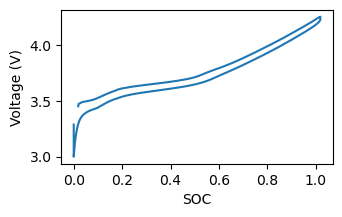

In [9]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.plot(raw_data['soc'], raw_data['voltage'])
ax.set_ylabel('Voltage (V)')
ax.set_xlabel('SOC')

The voltage during charge and discharge are different. Moirae accounts for this by weighing points with lower current more strongly and fitting a [smoothing spline](https://docs.scipy.org/doc/scipy/tutorial/interpolate/smoothing_splines.html#object-oriented-univariatespline).

> Note: Make the spline fit data more closely by increating the number of SOC points

In [10]:
from moirae.extractors.ecm import OCVExtractor
ocv = OCVExtractor(capacity=cap).extract(data)

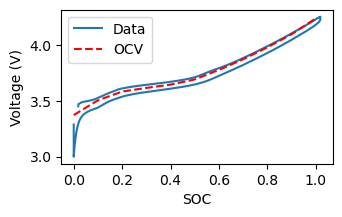

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.plot(raw_data['soc'], raw_data['voltage'], label='Data')
soc = np.linspace(0, 1, 64)
fit = ocv(soc)
ax.plot(soc, fit[0, :], 'r--', label='OCV')
ax.set_ylabel('Voltage (V)')
ax.set_xlabel('SOC')

ax.legend()

This yields a generally-good representation of the OCV.

## Instantaneous Resistance (R0) Extractor
The `R0Extractor` estimates the instantaneous resistance in the battery as a function of SOC from current steps observed in the current-voltage-time data.

We need to load a CellDataset that contains such details to demonstrate the usage of the extractor. In this case, we use a simulated dataset that represents a hybrid pulse power characterization test commonly used for electric vehicles.

In [12]:
data = BatteryDataset.from_hdf('files/hppc.h5')
data.tables['raw_data']['state'] = data.tables['raw_data']['state'].str.decode('utf-8')

First, we visualize the simulated data:

Text(0.5, 0, 'Time (hr)')

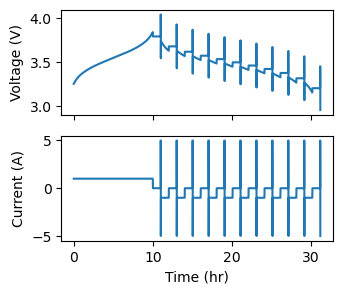

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(3.5, 3.), sharex=True)

raw_data = data.tables['raw_data']
time = (raw_data['test_time'] - raw_data['test_time'].min()) / 3600
axs[0].plot(time, raw_data['voltage'])
axs[0].set_ylabel('Voltage (V)')
axs[1].plot(time, raw_data['current'])
axs[1].set_ylabel('Current (A)')
axs[1].set_xlabel('Time (hr)')

Now we employ the extractor to identify the current steps observed in the raw data and estimate the resistance as a function of SOC. The extractor takes as input an optional parameter, `dt_max`, that determines the maximum allowable timestep for the computation of the R0. We set this to 11 seconds, as the data collection frequency for the dataset is 10 seconds. In real applications, a much smaller `dt_max` is recommended.

In [14]:
from moirae.extractors.ecm import R0Extractor
ext = R0Extractor(capacity=10, dt_max=11)
r0 = ext.extract(data)

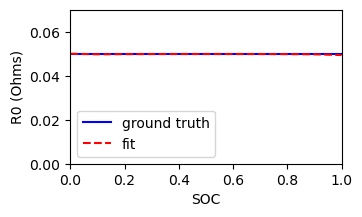

In [15]:
fig, ax = plt.subplots(figsize=(3.5, 2.))
soc = np.linspace(0, 1, 64)
fit = r0.get_value(soc)
ax.plot(soc, 0.05*np.ones(soc.shape), 'b-', label='ground truth')
ax.plot(soc, fit[0, :], 'r--', label='fit')
ax.set_ylabel('R0 (Ohms)')
ax.set_xlabel('SOC')
ax.set_xlim(0, 1)
ax.set_ylim(0, 0.07)
ax.legend()

The extracted R0 is close to the ground truth, with less than 1% error across the SOC range.

## Resistor-Capacitor (RC) Couple Extractor
The `RCExtractor` estimates the parameters of the RC couples as a function of SOC from post-discharge or charge rests observed in the current-voltage-time data.

We will load a version of the HPPC dataset used for the previous example that contains a single RC pair and higher sampling rate.

In [16]:
data = BatteryDataset.from_hdf('files/hppc_1rc.h5')
data.tables['raw_data']['state'] = data.tables['raw_data']['state'].str.decode('utf-8')

First, we visualize the simulated data:

Text(0.5, 0, 'Time (hrs)')

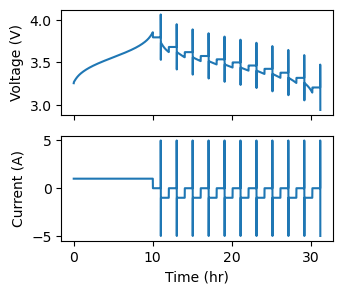

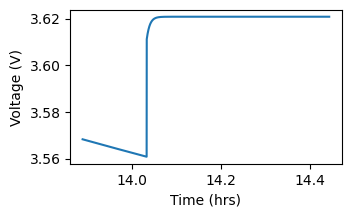

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(3.5, 3.), sharex=True)

raw_data = data.tables['raw_data']
time = (raw_data['test_time'] - raw_data['test_time'].min()) / 3600
axs[0].plot(time, raw_data['voltage'])
axs[0].set_ylabel('Voltage (V)')
axs[1].plot(time, raw_data['current'])
axs[1].set_ylabel('Current (A)')
axs[1].set_xlabel('Time (hr)')

fig, ax = plt.subplots(figsize=(3.5, 2.))
ax.plot(time.iloc[50000:52000], raw_data['voltage'].iloc[50000:52000])
ax.set_ylabel('Voltage (V)')
ax.set_xlabel('Time (hrs)')

Now we employ the extractor to identify the relevant rests observed in the raw data and estimate the RC parameters as a function of SOC.

In [18]:
from moirae.extractors.ecm import RCExtractor
from battdat.postprocess.integral import StateOfCharge, CapacityPerCycle
ext = RCExtractor(capacity=10)
StateOfCharge().enhance(data.tables['raw_data'])
rc = ext.extract(data)

(0.0, 3000.0)

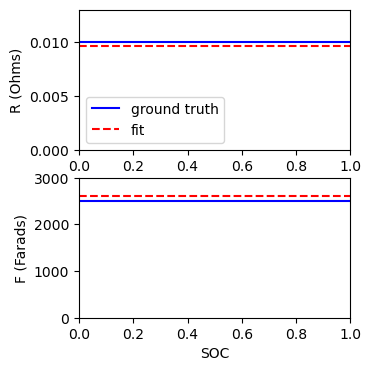

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(3.5, 4.))

soc = np.linspace(0, 1, 64)
fit = rc[0].get_value(soc)

axs[0].plot(soc, 0.01*np.ones(soc.shape), 'b-', label='ground truth')
axs[0].plot(soc, np.squeeze(fit[0]), 'r--', label='fit')
axs[0].set_ylabel('R (Ohms)')
axs[0].set_xlabel('SOC')
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 0.013)
axs[0].legend()

axs[1].plot(soc, 2500*np.ones(soc.shape), 'b-')
axs[1].plot(soc, np.squeeze(fit[1]), 'r--')
axs[1].set_ylabel('F (Farads)')
axs[1].set_xlabel('SOC')
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 3000)